In [1]:
import os
import sys
sys.path.append('../../..')

import cv2
import copy
import numpy as np

%load_ext autoreload
%autoreload 2

from computer_vision.yolov11.modules.detector import DetectionModel
from computer_vision.yolov11.parameter_parser import parser
from computer_vision.yolov11.utils.check import check_imgsz
from computer_vision.yolov11.data.dataset import YOLODataset
from computer_vision.misc import alpha_bending
from computer_vision.yolov11.misc import instance2mask

In [2]:
data_dirpath=r'D:/data/ultralytics/coco128-seg'

argument=f'''--root {data_dirpath} --image-dirname images/train2017 --label-dirname labels/train2017
--data-cfg ../coco128-seg.yaml --hyperparam ../default.yaml '''
args=parser.parse_args(argument.split())

model=DetectionModel(cfg='../yolo11.yaml', ch=3)
print('stride ', model.stride)
gs = max(int(model.stride.max() if hasattr(model, "stride") else 32), 32)  # grid size (max stride)
print('grid size ', gs)
check_imgsz(args.imgsz, stride=gs, floor=gs, max_dim=1) # args.imgsz 

dataset=YOLODataset(img_path=os.path.join(args.root, args.image_dirname),label_path=os.path.join(args.root, args.label_dirname),
                    data=args.data_cfg, hyp=args.hyperparam, imgsz=640, cache=True, augment=True, rect=False, batch_size=8, stride=32, pad=0.5, 
                    single_cls=False, classes=None, fraction=1., channels=3)

print('dataset.im_files ', len(dataset.im_files))

In BaseModel._predict_once max_idx -1 embed {-1}
stride  tensor([ 8., 16., 32.])
grid size  32
In data.dataset.YOLODataset.update_images_labels cache path D:\data\ultralytics\coco128-seg\labels\train2017.cache exist. Load it!!!
Scanning D:\data\ultralytics\coco128-seg\labels\train2017.cache ... 126 images with 2 missing and 0 empty files as well as 0 corrupt files
max_buffer_length  64  ni  128
dataset.im_files  128


In [3]:
from __future__ import annotations

import random
from typing import Any

import numpy as np

from computer_vision.yolov11.instance.instance import Instances
from computer_vision.yolov11.data.augment import Compose, Mosaic, MixUp, CutMix, RandomPerspective,\
RandomHSV, RandomFlip, LetterBox, CopyPaste
from computer_vision.yolov11.utils.ops import xywhn2xyxy, xywh2xyxy
from computer_vision.yolov11.data.utils import imread

from matplotlib import patches
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab10', 10)
plt.rcParams.update({'font.size'   : 12})

In data.dataset.load_image self.buffer 22
In data.dataset.load_image self.buffer 23
In data.dataset.load_image self.buffer 24
In data.dataset.load_image self.buffer 25
In data.dataset.load_image self.buffer 26
img  (640, 640, 3) height 640, width 640
img  (640, 640, 3) height 640, width 640


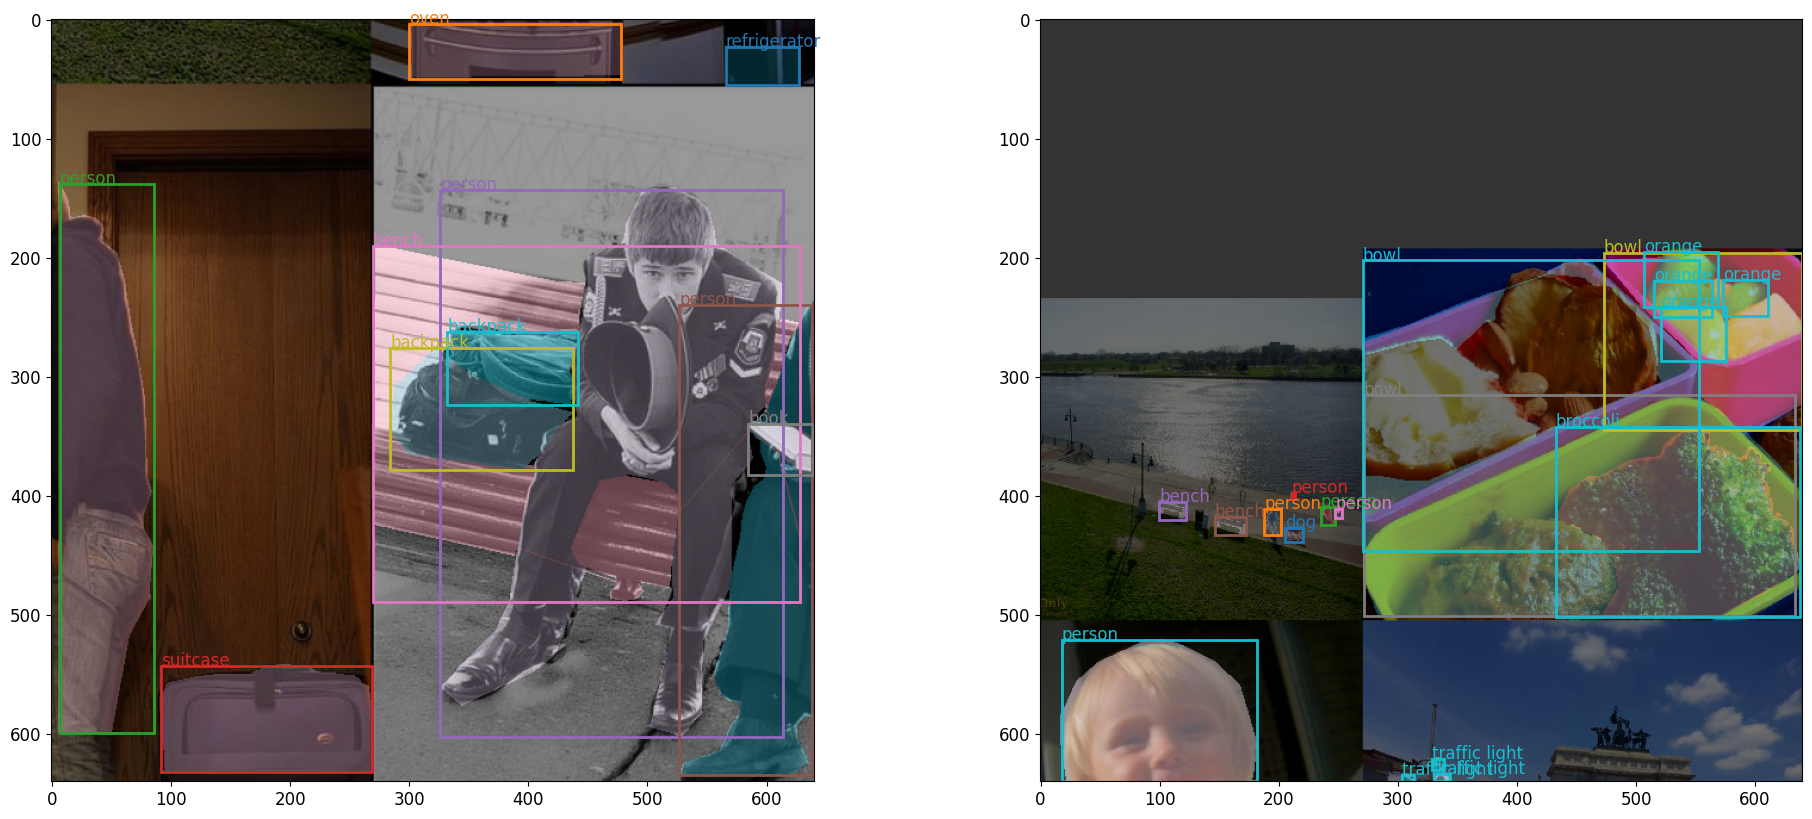

In [6]:
import yaml
from pathlib import Path 

hyp=Path(args.hyperparam)
assert hyp.is_file(), f'{hyp} does not exist'
with open(hyp) as f: hyp=yaml.load(f, Loader=yaml.SafeLoader)

mosaic=Mosaic(dataset, imgsz=dataset.imgsz, p=hyp['mosaic'], n=4)
affine=RandomPerspective(degrees=hyp['degrees'], translate=hyp['translate'],
                        scale=hyp['scale'], shear=hyp['shear'], perspective=hyp['perspective'],
                        pre_transform=None)
pre_transform=Compose([mosaic, affine])
transforms=Compose([pre_transform,
                   MixUp(dataset, pre_transform=pre_transform, p=hyp['mixup']),
                   CutMix(dataset, pre_transform=pre_transform, p=hyp['cutmix']),
                   RandomHSV(hgain=hyp['hsv_h'], sgain=hyp['hsv_s'], vgain=hyp['hsv_v']),
                   RandomFlip(direction='vertical', p=hyp['flipud']),
                   RandomFlip(direction='horizontal', p=hyp['fliplr'])])

labels=dataset.get_image_and_label(index=20) # 90, 10
pre_labels=pre_transform(copy.deepcopy(labels))
final_labels=transforms(labels)

_, ax=plt.subplots(1,2,figsize=(20,8))
for i, labels in enumerate([pre_labels, final_labels]):
    classes=[dataset.data['names'][int(c)] for c in labels['cls'].flatten()]
    img=labels['img']
    height, width=img.shape[:2]
    print('img ', img.shape, f'height {height}, width {width}')
    instances=copy.deepcopy(labels['instances'])
    if instances._bboxes.format=='xywh': instances.convert_bbox('xyxy')
    if instances.normalized: instances.denormalize()
    boxes=instances.bboxes

    mask=instance2mask(image=img, instance=labels['instances'])
    ax[i].imshow(alpha_bending(mask, img[...,::-1], 0.4))
    # ax[i].imshow(img[...,::-1])
    for j, (box,cls) in enumerate(zip(boxes, classes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
        ax[i].text(*box[:2], f'{cls}', color=cmap(j), fontsize=12)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)


In data.dataset.load_image self.buffer 27
In data.dataset.load_image self.buffer 28
In data.dataset.load_image self.buffer 29
In data.dataset.load_image self.buffer 30
In data.dataset.load_image self.buffer 31
In data.dataset.load_image self.buffer 32
In data.dataset.load_image self.buffer 33
In data.dataset.load_image self.buffer 34
In data.dataset.load_image self.buffer 35
In data.dataset.load_image self.buffer 36
In data.dataset.load_image self.buffer 37
In data.dataset.load_image self.buffer 38
img  (640, 640, 3) height 640, width 640
img  (640, 640, 3) height 640, width 640


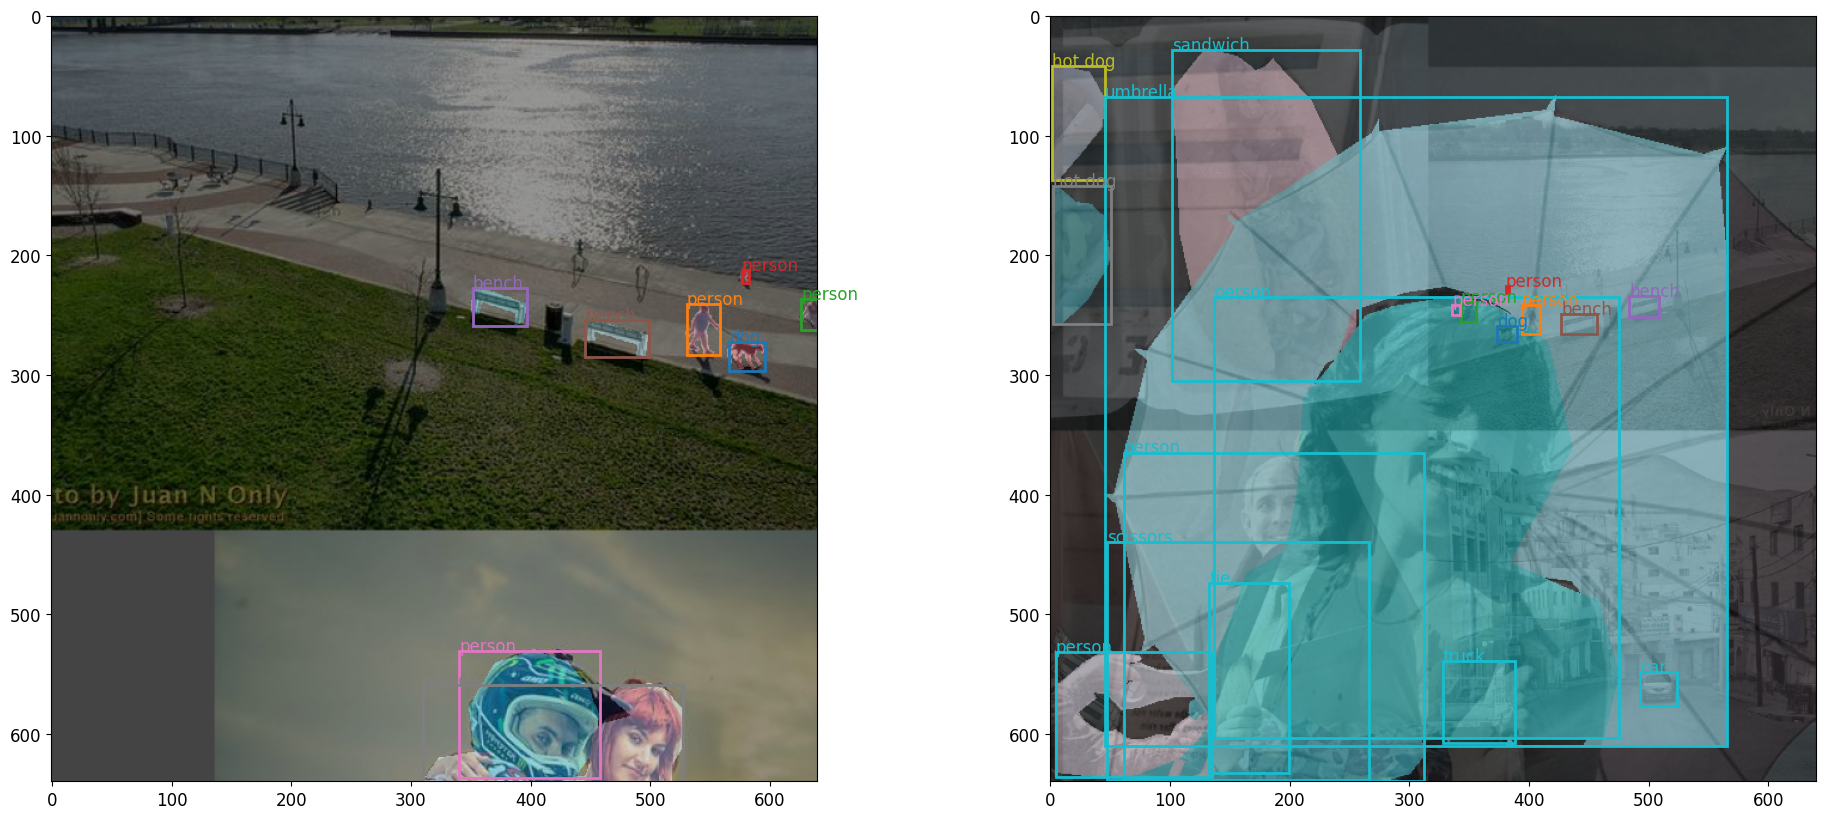

In [7]:
import yaml
from pathlib import Path 

hyp=Path(args.hyperparam)
assert hyp.is_file(), f'{hyp} does not exist'
with open(hyp) as f: hyp=yaml.load(f, Loader=yaml.SafeLoader)

mosaic=Mosaic(dataset, imgsz=dataset.imgsz, p=hyp['mosaic'], n=4)
affine=RandomPerspective(degrees=hyp['degrees'], translate=hyp['translate'],
                        scale=hyp['scale'], shear=hyp['shear'], perspective=hyp['perspective'],
                        pre_transform=None)
pre_transform=Compose([mosaic, affine])
transforms=Compose([pre_transform,
                   MixUp(dataset, pre_transform=pre_transform, p=1.),
                   CutMix(dataset, pre_transform=pre_transform, p=1.),
                   RandomHSV(hgain=hyp['hsv_h'], sgain=hyp['hsv_s'], vgain=hyp['hsv_v']),
                   RandomFlip(direction='vertical', p=hyp['flipud']),
                   RandomFlip(direction='horizontal', p=hyp['fliplr'])])

labels=dataset.get_image_and_label(index=20) # 90, 10
pre_labels=pre_transform(copy.deepcopy(labels))
final_labels=transforms(labels)

_, ax=plt.subplots(1,2,figsize=(20,8))
for i, labels in enumerate([pre_labels, final_labels]):
    classes=[dataset.data['names'][int(c)] for c in labels['cls'].flatten()]
    img=labels['img']
    height, width=img.shape[:2]
    print('img ', img.shape, f'height {height}, width {width}')
    instances=copy.deepcopy(labels['instances'])
    if instances._bboxes.format=='xywh': instances.convert_bbox('xyxy')
    if instances.normalized: instances.denormalize()
    boxes=instances.bboxes

    mask=instance2mask(image=img, instance=labels['instances'])
    ax[i].imshow(alpha_bending(mask, img[...,::-1], 0.4))
    # ax[i].imshow(img[...,::-1])
    for j, (box,cls) in enumerate(zip(boxes, classes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
        ax[i].text(*box[:2], f'{cls}', color=cmap(j), fontsize=12)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
